In [45]:
# !pip install pytorch torchvision gdown

import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.datasets import CelebA
import torchvision
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

from model import Generator, Discriminator

# Set device type
device = "cuda" if torch.cuda.is_available() else "cpu"

# Reproducibility
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

In [46]:
# Loads the celebA dataset from pytorch datasets, and saves only 10000 images to local dir
# Run this cell only once (if the data is not already downloaded)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    # this centers the data around 0 and scales it to [-1, 1] - to make training more stable for the generator
])

celebA = datasets.CelebA(root='data', split='all', download=True, transform=transform)
# celebA = datasets.ImageFolder(root='data/celebA', transform=transform)

# keep only 10000 random images
# celebA = torch.utils.data.Subset(celebA, torch.randperm(len(celebA))[:10000])

# Split into train and test
# train_size, test_size = int(0.8 * len(celebA)), int(0.2 * len(celebA))
# train_set, test_set = torch.utils.data.random_split(celebA, [train_size, test_size])

# save to local dir
# torch.save(train_set, 'data/celebA_train.pth')
# torch.save(test_set, 'data/celebA_test.pth')

Image shape: torch.Size([3, 128, 128])


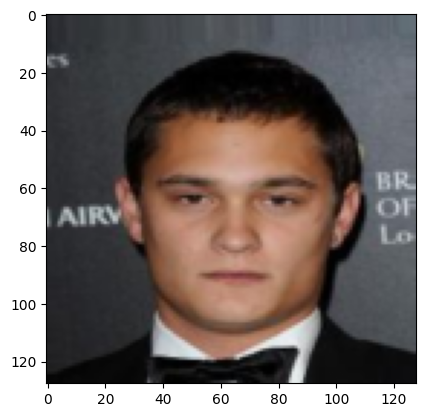

In [47]:
# Load the celebA dataset from local dir
train_set = torch.load('data/celebA_train.pth')
test_set = torch.load('data/celebA_test.pth')

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True if device == 'cuda' else False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, pin_memory=True if device == 'cuda' else False)

print("Image shape:", train_loader.dataset[0][0].shape)

def unnormalize(img):
    # unnormalize (we normalized the data to [-1, 1] before)
    return img / 2 + 0.5

img_sample = train_loader.dataset[0][0]
img_sample = unnormalize(img_sample)
plt.imshow(np.transpose(img_sample.numpy(), (1, 2, 0))) # transpose (C, H, W) -> (H, W, C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


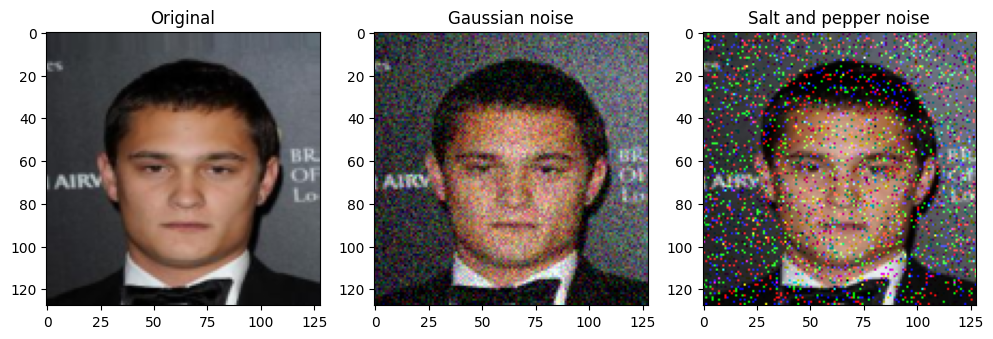

In [48]:
# Different noise functions
def gaussian_noise(image, noise_level):
    image_clone = image.clone()
    noise = torch.randn_like(image) * noise_level
    return image_clone + noise

def salt_and_pepper_noise(image, noise_level):
    image_clone = image.clone()
    noise = torch.rand_like(image_clone)
    image_clone[noise < noise_level / 2] = 0
    image_clone[noise > 1 - noise_level / 2] = 1
    return image_clone

def gaussian_or_salt(image, noise_levels):
    if np.random.rand() < 0.5:
        return gaussian_noise(image, noise_levels)
    else:
        return salt_and_pepper_noise(image, noise_levels)

# Plot one example of each noise type
gaussian_sample = gaussian_noise(img_sample, 0.1)
salt_and_pepper_sample = salt_and_pepper_noise(img_sample, 0.1)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(img_sample.numpy().transpose(1, 2, 0))
ax[0].set_title('Original')
ax[1].imshow(gaussian_sample.numpy().transpose(1, 2, 0))
ax[1].set_title('Gaussian noise')
ax[2].imshow(salt_and_pepper_sample.numpy().transpose(1, 2, 0))
ax[2].set_title('Salt and pepper noise')
plt.show()

In [56]:
# for checkpointing
import os
if not os.path.exists('models'):
    os.makedirs('models')

def train(generator, discriminator, train_loader, criterion, content_criterion, generator_optimizer, discriminator_optimizer, num_epochs=1, noise_level_range = (0.1, 0.01), noise_function=gaussian_noise, model_name_save='model', test_run = False):
    generator.train()
    discriminator.train()
    losses_gen, losses_disc = [], []

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(tqdm(train_loader)):
            # Test the training:
            if test_run and i == 5:
                break

            noise_level = np.random.uniform(*noise_level_range)
            real_images_noisy = noise_function(real_images, noise_level).to(device)

            # Train the discriminator
            discriminator_optimizer.zero_grad()
            generator_optimizer.zero_grad()

            fake_images = generator(real_images_noisy).to(device)
            real_disc = discriminator(real_images)
            fake_disc = discriminator(fake_images)

            real_loss = criterion(real_disc, torch.ones_like(real_disc))
            fake_loss = criterion(fake_disc, torch.zeros_like(fake_disc))
            disc_loss = (real_loss + fake_loss) / 2

            disc_loss.backward()
            discriminator_optimizer.step()

            # Train the generator
            discriminator_optimizer.zero_grad()
            generator_optimizer.zero_grad()

            fake_images = generator(real_images_noisy)
            fake_disc = discriminator(fake_images)

            content_loss = content_criterion(fake_images, real_images)
            gen_loss = 0.1 * criterion(fake_disc, torch.ones_like(fake_disc)) + 0.9 * content_loss

            gen_loss.backward()
            generator_optimizer.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], "
                      f"Generator loss: {gen_loss.item():.4f}, Discriminator loss: {disc_loss.item():.4f}")

            losses_gen.append(gen_loss.item())
            losses_disc.append(disc_loss.item())

        # Checkpoint the model after each epoch
        torch.save(generator.state_dict(), f'./models/{model_name_save}_generator_epoch_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'./models/{model_name_save}_discriminator_epoch_{epoch}.pth')

    # Save the losses
    with open(f'./models/{model_name_save}_losses.pkl', 'wb') as f:
        pickle.dump((losses_gen, losses_disc), f)

    return losses_gen, losses_disc

def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100  # means no noise is present
    return 20 * torch.log10(1.0 / torch.sqrt(mse)) # 1.0 is the max possible pixel value

def test(generator, test_loader, noise_level=0.05, noise_function=gaussian_noise, model_name='model'):
    generator.eval()
    psnr_score = 0

    with torch.no_grad():
        for i, (real_images, _) in enumerate(tqdm(test_loader)):
            real_images_noisy = noise_function(real_images, noise_level)
            fake_images = generator(real_images_noisy)

            psnr_score += psnr(real_images, fake_images)

    # Save the test score
    with open(f'./models/{model_name}_psnr.txt', 'w') as f:
        f.write(f"Average PSNR: {psnr_score / len(test_loader)}")

    return psnr_score / len(test_loader)

In [63]:
def run_model(num_epochs=1, noise_level_train=(0.1, 0.01), noise_function=gaussian_noise, model_name_save='model', test_run=False):
    generator = Generator(in_channels=3).to(device)
    discriminator = Discriminator(input_size=128*128, in_channels=3).to(device)

    # Loss functions
    criterion = nn.BCEWithLogitsLoss()
    content_criterion = nn.L1Loss()

    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    losses_gen, losses_disc = train(generator, discriminator, train_loader, criterion, content_criterion, generator_optimizer, discriminator_optimizer, num_epochs=num_epochs, noise_level_range=noise_level_train, noise_function=noise_function, model_name_save=model_name_save, test_run=test_run)

    # Test the model
    noise_level_test1 = 0.01
    noise_level_test2 = 0.05
    noise_level_test3 = 0.1

    psnr_score1 = test(generator, test_loader, noise_level=noise_level_test1, noise_function=noise_function, model_name=model_name_save+"01")
    psnr_score2 = test(generator, test_loader, noise_level=noise_level_test2, noise_function=noise_function, model_name=model_name_save+"05")
    psnr_score3 = test(generator, test_loader, noise_level=noise_level_test3, noise_function=noise_function, model_name=model_name_save+"1")

    print(f"Average PSNR 0.01: {psnr_score1}")
    print(f"Average PSNR 0.05: {psnr_score2}")
    print(f"Average PSNR 0.1: {psnr_score3}")

    # Plot the losses
    plt.plot(losses_gen, label='Generator loss')
    plt.plot(losses_disc, label='Discriminator loss')
    plt.legend()
    plt.show()

  0%|          | 1/250 [00:16<1:06:40, 16.07s/it]

Epoch [0/1], Step [0/250], Generator loss: 0.6974, Discriminator loss: 0.7208


100%|██████████| 63/63 [02:19<00:00,  2.22s/it]


Average PSNR 0.01: 1.4589834213256836


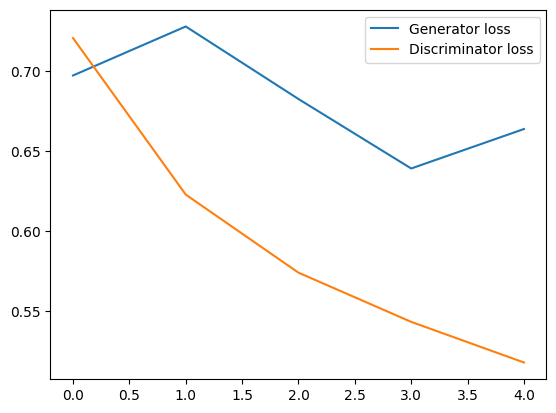

In [65]:
# 0.05 gaussian noise model
run_model(num_epochs=6, noise_level_train=(0.05, 0.05), noise_function=gaussian_noise, model_name_save='gaussian_05')

In [51]:
# 0.01-0.1 gaussian noise model
run_model(num_epochs=6, noise_level_train=(0.01, 0.1), noise_function=gaussian_noise, model_name_save='gaussian_01_1')

  0%|          | 1/250 [00:13<57:44, 13.91s/it]

Epoch [0/1], Step [0/250], Generator loss: 0.6891, Discriminator loss: 0.7190


  1%|          | 3/250 [00:49<1:07:18, 16.35s/it]


KeyboardInterrupt: 

In [ ]:
# 0.05 salt and pepper noise model
run_model(num_epochs=6, noise_level_train=(0.05, 0.05), noise_function=salt_and_pepper_noise, model_name_save='salt_05')

In [53]:
# 0.01-0.1 salt and pepper noise model
run_model(num_epochs=6, noise_level_train=(0.01, 0.1), noise_function=salt_and_pepper_noise, model_name_save='salt_01_1')

  0%|          | 1/250 [00:20<1:25:46, 20.67s/it]

Epoch [0/1], Step [0/250], Generator loss: 0.6295, Discriminator loss: 0.7261


  2%|▏         | 4/250 [01:13<1:14:58, 18.29s/it]


KeyboardInterrupt: 

In [ ]:
# TODO: plot the psnr across the epochs, after training

In [ ]:
# Visualize the denoising
# generator.eval()
# discriminator.eval()
#
# noise_level = 0.05
# real_image = train_loader.dataset[0][0].unsqueeze(0)
# real_image_noisy = gaussian_noise(real_image, noise_level)
# fake_image = generator(real_image_noisy)
#
# fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# ax[0].imshow(unnormalize(real_image).numpy().squeeze().transpose(1, 2, 0))
# ax[0].set_title('Real image')
# ax[1].imshow(unnormalize(real_image_noisy).squeeze().numpy().transpose(1, 2, 0))
# ax[1].set_title('Noisy image')
# ax[2].imshow(unnormalize(fake_image).detach().squeeze().numpy().transpose(1, 2, 0))
# ax[2].set_title('Denoised image')
# plt.show()